In [1]:
import pandas as pd
import numpy as np
import string
import re
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, LSTM, Dense,Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import euclidean
import warnings
warnings.filterwarnings('ignore')

## Phoneme to Sentences conversion using classification approach

In one of our last notebooks we looked at how could we convert 
<a url = "https://www.kaggle.com/code/poojag718/phoneme-to-sentences-using-lstm-encoder-decoder"> Phoneme to sentences using LSTM(encoder-decoder)</a> approach. <br>
In this notebooks we are going to look at a different approach for solving the same problem
> Problem Statement: Given a set of phonemes and their sentence representation build a model which is able to predict sentences using phonemes.

## Step 1: Preparing the dataset
***Phoneme: In linguistics, a phoneme is the smallest sound unit in a language that is capable of conveying a distinct meaning, such as the s of sing and the r of ring.***

The data provided to us is divided into different dialect regions.In each dialect region there are different speakers.
We see that for each audio file there are:
* TXT file which has complete sentences that have been spoken by a speker
  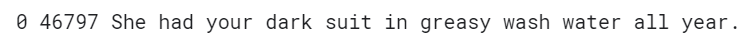
  here the numbers illustrate the the sentence spoken for that interval
* WRD file which consist of Words
  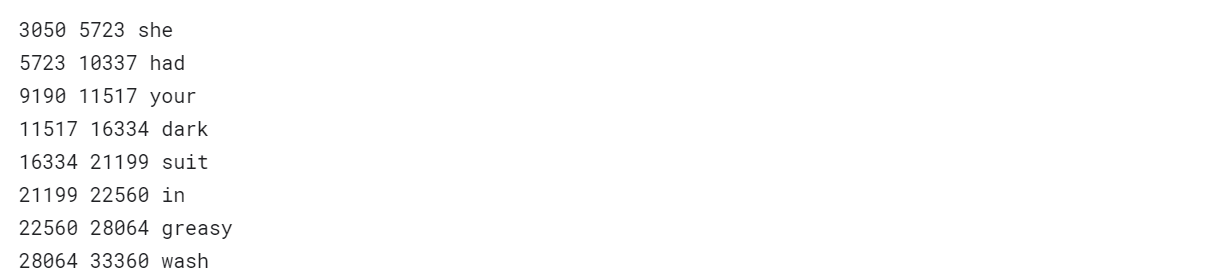
  here numbers indicate within what interval which word was spoken
* PHN file which consist of phonemes
  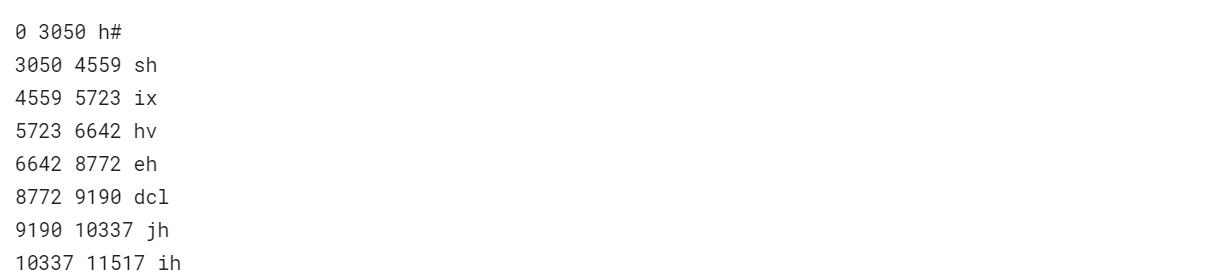
  here numbers indicate the phoneme for the words
  
If we look at the data properly well see that the total interval in Txt, WRD, PHN file matches. So we can use these interval values to collect the data for phonemes for each word by matching the interval values in WRD and PHN file.


We need the data in the following format:

|Phoneme|Word|
|------|------|
|sh ix |she   |
|hv eh dcl jh|had


In [2]:
data = pd.read_csv("../input/darpa-timit-acousticphonetic-continuous-speech/train_data.csv")
data.head()

,index,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
0,1.0,TRAIN,DR4,MMDM0,SI681.WAV.wav,TRAIN/DR4/MMDM0/SI681.WAV.wav,TRAIN\\DR4\\MMDM0\\SI681.WAV.wav,True,True,False,False,False
1,2.0,TRAIN,DR4,MMDM0,SI1311.PHN,TRAIN/DR4/MMDM0/SI1311.PHN,TRAIN\\DR4\\MMDM0\\SI1311.PHN,False,False,False,True,False
2,3.0,TRAIN,DR4,MMDM0,SI1311.WRD,TRAIN/DR4/MMDM0/SI1311.WRD,TRAIN\\DR4\\MMDM0\\SI1311.WRD,False,False,True,False,False
3,4.0,TRAIN,DR4,MMDM0,SX321.PHN,TRAIN/DR4/MMDM0/SX321.PHN,TRAIN\\DR4\\MMDM0\\SX321.PHN,False,False,False,True,False
4,5.0,TRAIN,DR4,MMDM0,SX321.WRD,TRAIN/DR4/MMDM0/SX321.WRD,TRAIN\\DR4\\MMDM0\\SX321.WRD,False,False,True,False,False


In [3]:
## Selecting only txt files
data_txt = data[(data["is_sentence_file"] == True) & (data["dialect_region"].isin(["DR1","DR2","DR3"]))]
data_txt.head()

,index,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
3403,3404.0,TRAIN,DR3,MDNS0,SX111.TXT,TRAIN/DR3/MDNS0/SX111.TXT,TRAIN\\DR3\\MDNS0\\SX111.TXT,False,False,False,False,True
3408,3409.0,TRAIN,DR3,MDNS0,SI873.TXT,TRAIN/DR3/MDNS0/SI873.TXT,TRAIN\\DR3\\MDNS0\\SI873.TXT,False,False,False,False,True
3412,3413.0,TRAIN,DR3,MDNS0,SI2271.TXT,TRAIN/DR3/MDNS0/SI2271.TXT,TRAIN\\DR3\\MDNS0\\SI2271.TXT,False,False,False,False,True
3413,3414.0,TRAIN,DR3,MDNS0,SX201.TXT,TRAIN/DR3/MDNS0/SX201.TXT,TRAIN\\DR3\\MDNS0\\SX201.TXT,False,False,False,False,True
3415,3416.0,TRAIN,DR3,MDNS0,SA1.TXT,TRAIN/DR3/MDNS0/SA1.TXT,TRAIN\\DR3\\MDNS0\\SA1.TXT,False,False,False,False,True


In [4]:
## to create columns with PHN and WRD file path
def add_phn(a):
    a = a[:-3]
    a = a+"PHN" 
    return a
def add_word(a):
    a = a[:-3]
    a = a+"WRD" 
    return a

In [5]:
data_txt["Phoneme"] = ''
data_txt["Phoneme"] = data_txt["path_from_data_dir"].apply(lambda x: add_phn(x))
data_txt["Word"] = ""
data_txt["Word"] = data_txt["path_from_data_dir"].apply(lambda x: add_word(x))

In [6]:
data_txt= data_txt[["index","test_or_train","dialect_region","speaker_id",
            "path_from_data_dir","Phoneme","Word"]]
## Renaming columns for convineince
data_txt.columns = ["index","test_or_train","dialect_region","speaker_id",
                    "Text","Phoneme","Word"]

In [7]:
data_txt["Text"] = "../input/darpa-timit-acousticphonetic-continuous-speech/data/"+data_txt["Text"]
data_txt["Phoneme"] = "../input/darpa-timit-acousticphonetic-continuous-speech/data/"+data_txt["Phoneme"]
data_txt["Word"] = "../input/darpa-timit-acousticphonetic-continuous-speech/data/"+data_txt["Word"]
data_txt.head()

,index,test_or_train,dialect_region,speaker_id,Text,Phoneme,Word
3403,3404.0,TRAIN,DR3,MDNS0,../input/darpa-timit-acousticphonetic-continuo...,../input/darpa-timit-acousticphonetic-continuo...,../input/darpa-timit-acousticphonetic-continuo...
3408,3409.0,TRAIN,DR3,MDNS0,../input/darpa-timit-acousticphonetic-continuo...,../input/darpa-timit-acousticphonetic-continuo...,../input/darpa-timit-acousticphonetic-continuo...
3412,3413.0,TRAIN,DR3,MDNS0,../input/darpa-timit-acousticphonetic-continuo...,../input/darpa-timit-acousticphonetic-continuo...,../input/darpa-timit-acousticphonetic-continuo...
3413,3414.0,TRAIN,DR3,MDNS0,../input/darpa-timit-acousticphonetic-continuo...,../input/darpa-timit-acousticphonetic-continuo...,../input/darpa-timit-acousticphonetic-continuo...
3415,3416.0,TRAIN,DR3,MDNS0,../input/darpa-timit-acousticphonetic-continuo...,../input/darpa-timit-acousticphonetic-continuo...,../input/darpa-timit-acousticphonetic-continuo...


#### Training and Testing Data
We are going to consider 
* DR1 and DR2 for training
* DR3 for testing

In [8]:
Train = data_txt[(data_txt["dialect_region"] == "DR1")|
            (data_txt["dialect_region"] == "DR2")]
Test = data_txt[data_txt["dialect_region"] == "DR3"]

In [9]:
## defining a function for extracting wach word and the respective phoneme
def word_phoneme(path,path2):
    w = []
    p = []
    with open(path1) as wrd:
        for line in wrd.readlines():
            word = line.split(" ")
            w.append(word)
    with open(path2) as ph:
        for line in ph.readlines():
            phoneme = line.split(" ")
            p.append(phoneme)
            
    p_copy = p[1:-1]
    word = []
    phoneme = []
    j = 0
    for i in range(len(w)):
        word.append(w[i][2])
        word_p = []
        while(j != len(p_copy)):
            if(w[i][0] == p_copy[j][0] and w[i][1] == p_copy[j][1] ):
                word_p.append(p_copy[j][2]) 
                j = j+1
                break
            elif(w[i][0] == p_copy[j][0]):
                word_p.append(p_copy[j][2]) 
                j = j+1
            elif (w[i][1] != p_copy[j][1]):
                word_p.append(p_copy[j][2])
                j = j+1
            elif (w[i][1] == p_copy[j][1]):
                word_p.append(p_copy[j][2])
                j = j+1
                break
        phoneme.append(word_p)
    word = [re.sub("\n","",i) for i in word ]

    phoneme_combined = []
    for j in phoneme:
        a = []
        for i in j:
            b = re.sub("\n","",i)
            a.append(b)
        a = ' '.join(a)
        phoneme_combined.append(a)
    return word,phoneme_combined

In [10]:
train_w_p = zip(Train["Word"],Train["Phoneme"])
test_w_p = zip(Test["Word"],Test["Phoneme"])

<div class="alert alert-block alert-info"> We are storing word and their phoneme at the same time we need to store complete sentences and their phonemes. While storing the sentences and their phonemes we seperate the phonemes for each respective word by two white spaces 
</div>

In [11]:
## to store each word and their phoneme
train_w = []
train_p = []
test_w = []
test_p = []
## To store complete sentence and their phoneme seperated by "  "
train_sentence = []
train_phoneme = []
test_sentence = []
test_phoneme = []

## train
for path1,path2 in train_w_p:
    word,phoneme = word_phoneme(path1,path2)
    train_sentence.append("  ".join(word))
    train_phoneme.append("  ".join(phoneme))
    for i in word:
        train_w.append(i)
    for j in phoneme:
        train_p.append(j)
        
## Test
for path1,path2 in test_w_p:
    word,phoneme = word_phoneme(path1,path2)
    test_sentence.append("  ".join(word))
    test_phoneme.append("  ".join(phoneme))
    for i in word:
        test_w.append(i)
    for j in phoneme:
        test_p.append(j)

In [12]:
train_vocab = {}
test_vocab = {}
for word,phoneme in zip(train_w,train_p):
    train_vocab[word] = phoneme
for word,phoneme in zip(test_w,test_p):
    test_vocab[word] = phoneme

In [13]:
## vocabulary is all the words in train and test vocab(union operation)
vocab = {**train_vocab,**test_vocab}

In [14]:
len(train_vocab)+len(test_vocab),len(vocab)

(4307, 3094)

**out of 4307 words in train and test, 3094 are unique which means only 1213 word is common between train and test** 

In [15]:
## Word and their phoneme
Train_vocab = pd.DataFrame({"Word":train_vocab.keys(),"Phoneme":train_vocab.values()})
Test_vocab = pd.DataFrame({"Word":test_vocab.keys(),"Phoneme":test_vocab.values()})
Vocab = pd.DataFrame({"Word":vocab.keys(),"Phoneme":vocab.values()})

In [16]:
Test_vocab.head()

,Word,Phoneme
0,his,hv ih z
1,sudden,ah dcl en
2,departure,dcl d iy pcl p aa r ch axr
3,shocked,sh aa kcl
4,the,dh ix


In [17]:
## Sentences and their respective phoneme
Train_file = pd.DataFrame()
Train_file["Sentence"] = train_sentence
Train_file["Phoneme"] = train_phoneme

Test_file = pd.DataFrame()
Test_file["Sentence"] = test_sentence
Test_file["Phoneme"] = test_phoneme


In [18]:
Train_file.head()

,Sentence,Phoneme
0,tofu is made from processed soybeans,t ow f uw ih z m ey dcl f r em pcl p r aa ...
1,i gave them several choices and let the...,ay gcl g ey v dh ah m s eh v r el tcl ch o...
2,she had your dark suit in greasy wash ...,sh iy hv ae dcl d y axr dcl d aa r kcl k s...
3,don't ask me to carry an oily rag like...,d ow n ae s kcl m iy dx ih kcl k eh r iy ...
4,a young mouse scampered across the field...,q ax y ah ng m aw s kcl k ae m pcl p axr dx...


In [19]:
Train_file["split"]  ="Train"
Test_file["split"] = "Test"

In [20]:
all_data = Train_file.append(Test_file)
all_data.reset_index(inplace=True)

<div class="alert alert-block alert-info"> Step 1 is completed we have formed the data now we need to train our model to be able to make predictions.</div>

## Step 2: Model Building
We are going to classify each word based on their phonemes using a bidirectional LSTM layer.

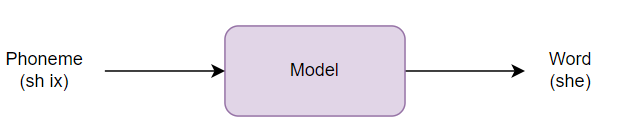

In [33]:
phoneme_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
phoneme_tokenizer.fit_on_texts(Vocab['Phoneme'].values)
phoneme_index = phoneme_tokenizer.word_index
print(phoneme_index)

{'<OOV>': 1, 's': 2, 'ix': 3, 'n': 4, 'tcl': 5, 'l': 6, 'kcl': 7, 'r': 8, 'k': 9, 'iy': 10, 'dcl': 11, 't': 12, 'ih': 13, 'm': 14, 'eh': 15, 'z': 16, 'pcl': 17, 'p': 18, 'd': 19, 'ae': 20, 'ax': 21, 'axr': 22, 'ey': 23, 'aa': 24, 'dx': 25, 'f': 26, 'b': 27, 'er': 28, 'bcl': 29, 'ay': 30, 'ah': 31, 'v': 32, 'ow': 33, 'q': 34, 'ng': 35, 'gcl': 36, 'ao': 37, 'w': 38, 'sh': 39, 'g': 40, 'el': 41, 'jh': 42, 'ux': 43, 'ch': 44, 'y': 45, 'epi': 46, 'nx': 47, 'en': 48, 'hv': 49, 'aw': 50, 'pau': 51, 'th': 52, 'uw': 53, 'hh': 54, 'dh': 55, 'oy': 56, 'uh': 57, 'h': 58, 'zh': 59, 'em': 60, 'eng': 61}


In [34]:
phoneme_length = len(phoneme_tokenizer.word_index) + 1
phoneme_length

62

In [35]:
train_sequences = phoneme_tokenizer.texts_to_sequences(Train_vocab['Phoneme'].values)
test_sequences = phoneme_tokenizer.texts_to_sequences(Test_vocab['Phoneme'].values)

In [36]:
longest_phoneme = len(max(train_sequences, key=len))
longest_phoneme

17

In [37]:
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=longest_phoneme, padding='post')
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=longest_phoneme, padding='post')

print("Word: {}\n Padded:{}\n phoneme:{}".format(Train_vocab["Word"][0],train_padded[0],Train_vocab["Phoneme"][0]))

Word: tofu
 Padded:[12 33 26 43  0  0  0  0  0  0  0  0  0  0  0  0  0]
 phoneme:t ow f ux


In [38]:
y = Vocab['Word'].values
y_train = Train_vocab['Word'].values
y_test = Test_vocab["Word"].values
                      
encoder = LabelEncoder()
encoder.fit(y)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
                      

#### Bidirectioan LSTM for Classification
<img src="https://miro.medium.com/max/1276/1*byNlw8jjJRIt9CYDjkDGQw.png" alt="alt text" title="Bidirectional LSTM for Classification" width="400"/>

In [39]:
embedding_dim = 10
tf.keras.backend.clear_session()
model = Sequential([
    Embedding(phoneme_length, embedding_dim, 
                              input_length=longest_phoneme),
    Bidirectional(LSTM(50)),
    Dense(128, activation='relu'),
    Dense(len(Vocab['Word'].unique()), activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 10)            620       
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               24400     
_________________________________________________________________
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
dense_1 (Dense)              (None, 3094)              399126    
Total params: 437,074
Trainable params: 437,074
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model.fit(train_padded,y_train,
                    batch_size=32,
                    epochs=50)

Epoch 1/50
75/75 [==============================] - 7s 28ms/step - loss: 8.0484
Epoch 2/50
75/75 [==============================] - 2s 28ms/step - loss: 8.0239
Epoch 3/50
75/75 [==============================] - 2s 27ms/step - loss: 8.0082
Epoch 4/50
75/75 [==============================] - 2s 27ms/step - loss: 7.9765
Epoch 5/50
75/75 [==============================] - 2s 27ms/step - loss: 7.8738
Epoch 6/50
75/75 [==============================] - 2s 28ms/step - loss: 7.5782
Epoch 7/50
75/75 [==============================] - 2s 27ms/step - loss: 7.0607
Epoch 8/50
75/75 [==============================] - 2s 27ms/step - loss: 6.3292
Epoch 9/50
75/75 [==============================] - 2s 27ms/step - loss: 5.6117
Epoch 10/50
75/75 [==============================] - 2s 27ms/step - loss: 4.9979
Epoch 11/50
75/75 [==============================] - 3s 36ms/step - loss: 4.4618
Epoch 12/50
75/75 [==============================] - 2s 28ms/step - loss: 3.9993
Epoch 13/50
75/75 [==================

<div class="alert alert-block alert-info"> Step 2 is completed now we are going to make prediction on sentences</div>

## Step 3: Making Predictions on sentences
* We have trained our model to predict a single word given their phonemes
* But out goal is to make prediction on sentences given their phonemes
* As you remember we stored phoneme for each word seperated by "  " (two white spaces
* So we are going to split our phoneme for each word and pass these phoneme and make prediction and concatenate the results to make sentences
* The flow for the same is shown in the diagram
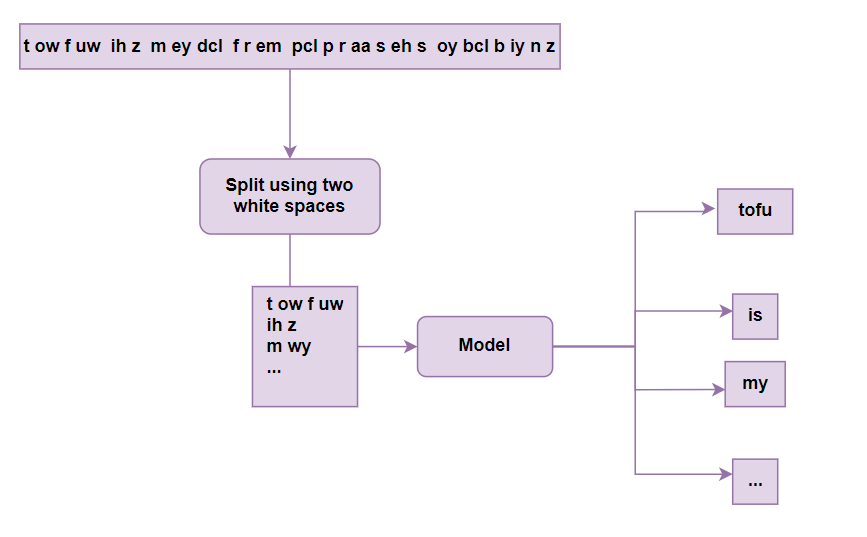


In [41]:
def predict_words(sentence):
    phonemes = sentence.split("  ")
    #print(phonemes)
    word_sentence = ""
    for x in phonemes:
        text_seq = phoneme_tokenizer.texts_to_sequences([x])
        text_padded = pad_sequences(text_seq, maxlen=longest_phoneme, padding='post')
        pred = model.predict(text_padded)
        pred = np.argmax(pred,axis=1)
        word = encoder.classes_[pred[0]]
        #print(word)
        word_sentence = word_sentence + word + " "
    word_sentence = word_sentence.strip()
    return word_sentence

In [42]:
## eg
predict_words("t ow f uw  ih z  m ey dcl  f r em  pcl p r aa s eh s  oy bcl b iy n z")

"author's how had fresh process soybeans"

In [43]:
all_data["predicted_sentence"] = all_data["Phoneme"].apply(predict_words)
all_data.head()

,index,Sentence,Phoneme,split,predicted_sentence
0,0,tofu is made from processed soybeans,t ow f uw ih z m ey dcl f r em pcl p r aa ...,Train,author's how had fresh process soybeans
1,1,i gave them several choices and let the...,ay gcl g ey v dh ah m s eh v r el tcl ch o...,Train,are gave warm speak atmosphere annoying let th...
2,2,she had your dark suit in greasy wash ...,sh iy hv ae dcl d y axr dcl d aa r kcl k s...,Train,she hood y'all dessert suit eat greasing wash ...
3,3,don't ask me to carry an oily rag like...,d ow n ae s kcl m iy dx ih kcl k eh r iy ...,Train,age waste who it carry an oily rag work gait
4,4,a young mouse scampered across the field...,q ax y ah ng m aw s kcl k ae m pcl p axr dx...,Train,al young mask scampered decking over reason an...


<div class="alert alert-block alert-info">Step 3 is completed now we are going to evaluate our model.</div>

* The model performance will not be great as we saw only 1213 words between train and test are common so we cannat use accuracy as a measure
* We'll try to evaluate the words based on their distance using embeddings

## Step 4: Evaluation based on Distance Measure

* We are going to represent each word as embedding using word2vec
* We will calculate the distance between words using euclidean distance 

In [44]:
from gensim.models import Word2Vec
vocab1 = [Vocab["Word"].to_list()]
w2v = Word2Vec(vocab1, min_count=0, vector_size = 32)

In [45]:
print(w2v.wv.get_vector("tofu"))

[ 0.01885236 -0.02820536 -0.00961708 -0.00879587  0.02141838  0.01138533
  0.00401808 -0.02292054 -0.01496863  0.01509115  0.01606498 -0.02437003
  0.02955227 -0.00771987  0.02929886  0.01298593  0.01144585 -0.00597659
 -0.01637369 -0.00735602  0.00818982 -0.00512621  0.02638491  0.02975898
 -0.0191319  -0.02428059  0.02492653 -0.02008551 -0.02237218  0.00555234
 -0.01094007  0.0005844 ]


In [46]:
def word_distances(w1,w2):
    x1 = w2v.wv.get_vector(w1)
    x2 = w2v.wv.get_vector(w2)
    distance = euclidean(x1,x2)
    return round(distance,2)

def total_distance(sent1,sent2):
    total_distance = 0
    for w1,w2 in zip(sent1.split(),sent2.split()):
        dist = word_distances(w1,w2)
        total_distance = total_distance + dist
    return total_distance

def word_distance(sent1,sent2):
    distance_word = []
    for w1,w2 in zip(sent1.split(),sent2.split()):
        dist = word_distances(w1,w2)
        distance_word.append(str(dist))
    a = ", ".join(distance_word)
    return a

In [47]:
## eg
total_distance("tofu  is  made  from  processed  soybeans","roles inch voice late process soybeans")

0.7400000000000001

In [48]:
all_data["total_distance"] = all_data.apply(lambda x: total_distance(x['Sentence'],x["predicted_sentence"]),axis = 1)
all_data["word_distance"] = all_data.apply(lambda x: word_distance(x['Sentence'],x["predicted_sentence"]),axis = 1)
all_data.head()

,index,Sentence,Phoneme,split,predicted_sentence,total_distance,word_distance
0,0,tofu is made from processed soybeans,t ow f uw ih z m ey dcl f r em pcl p r aa ...,Train,author's how had fresh process soybeans,0.72,"0.13, 0.16, 0.15, 0.12, 0.16, 0.0"
1,1,i gave them several choices and let the...,ay gcl g ey v dh ah m s eh v r el tcl ch o...,Train,are gave warm speak atmosphere annoying let th...,1.13,"0.13, 0.0, 0.17, 0.15, 0.13, 0.15, 0.0, 0.0, 0..."
2,2,she had your dark suit in greasy wash ...,sh iy hv ae dcl d y axr dcl d aa r kcl k s...,Train,she hood y'all dessert suit eat greasing wash ...,1.09,"0.0, 0.14, 0.16, 0.14, 0.0, 0.11, 0.12, 0.0, 0..."
3,3,don't ask me to carry an oily rag like...,d ow n ae s kcl m iy dx ih kcl k eh r iy ...,Train,age waste who it carry an oily rag work gait,0.79,"0.14, 0.13, 0.15, 0.12, 0.0, 0.0, 0.0, 0.0, 0...."
4,4,a young mouse scampered across the field...,q ax y ah ng m aw s kcl k ae m pcl p axr dx...,Train,al young mask scampered decking over reason an...,0.97,"0.15, 0.0, 0.16, 0.0, 0.14, 0.12, 0.14, 0.12, ..."


In [51]:
for i in range(10,15):
    print("Actual Sentence:",all_data["Sentence"][i])
    print("Predicted Sentence: ",all_data["predicted_sentence"][i])
    print("Word distance: ",all_data["word_distance"][i])
    print("Total distance: ",all_data["total_distance"][i])
    print("\n")

Actual Sentence: solid  concrete  blocks  relatively  heavy  and  dense  are  used  for  this  shelter
Predicted Sentence:  solid concrete blocks relatively heavy age dense 'em without full they shelter
Word distance:  0.0, 0.0, 0.0, 0.0, 0.0, 0.13, 0.0, 0.1, 0.14, 0.14, 0.1, 0.0
Total distance:  0.61


Actual Sentence: brush  fires  are  common  in  the  dry  underbrush  of  nevada
Predicted Sentence:  brush fires pie common inch over dry fatigues bob numbness
Word distance:  0.0, 0.0, 0.16, 0.0, 0.18, 0.12, 0.0, 0.18, 0.13, 0.13
Total distance:  0.8999999999999999


Actual Sentence: norwegian  sweaters  are  made  of  lamb's  wool
Predicted Sentence:  informative surprise art here of lamb's wool
Word distance:  0.15, 0.16, 0.17, 0.12, 0.0, 0.0, 0.0
Total distance:  0.6


Actual Sentence: she  had  your  dark  suit  in  greasy  wash  water  all  year
Predicted Sentence:  she tim y'all dessert suit kind greasing wash tiny all after
Word distance:  0.0, 0.13, 0.16, 0.14, 0.0, 0.13, 0.12

#### We will check how much data was actually predicted with total_distance less than 1, 2, and 3

In [52]:
def less_than(dist):
    if dist<1:
        return 1
    elif dist<2:
        return 2
    else:
        return 3
all_data["less_than"] = all_data["total_distance"].apply(less_than)

In [53]:
all_data.head()

,index,Sentence,Phoneme,split,predicted_sentence,total_distance,word_distance,less_than
0,0,tofu is made from processed soybeans,t ow f uw ih z m ey dcl f r em pcl p r aa ...,Train,author's how had fresh process soybeans,0.72,"0.13, 0.16, 0.15, 0.12, 0.16, 0.0",1
1,1,i gave them several choices and let the...,ay gcl g ey v dh ah m s eh v r el tcl ch o...,Train,are gave warm speak atmosphere annoying let th...,1.13,"0.13, 0.0, 0.17, 0.15, 0.13, 0.15, 0.0, 0.0, 0...",2
2,2,she had your dark suit in greasy wash ...,sh iy hv ae dcl d y axr dcl d aa r kcl k s...,Train,she hood y'all dessert suit eat greasing wash ...,1.09,"0.0, 0.14, 0.16, 0.14, 0.0, 0.11, 0.12, 0.0, 0...",2
3,3,don't ask me to carry an oily rag like...,d ow n ae s kcl m iy dx ih kcl k eh r iy ...,Train,age waste who it carry an oily rag work gait,0.79,"0.14, 0.13, 0.15, 0.12, 0.0, 0.0, 0.0, 0.0, 0....",1
4,4,a young mouse scampered across the field...,q ax y ah ng m aw s kcl k ae m pcl p axr dx...,Train,al young mask scampered decking over reason an...,0.97,"0.15, 0.0, 0.16, 0.0, 0.14, 0.12, 0.14, 0.12, ...",1


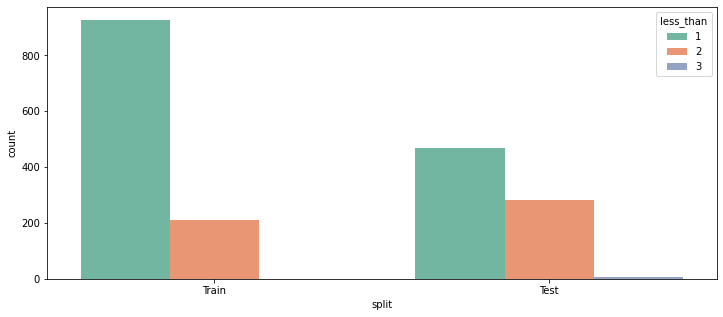

In [54]:
plt.figure(figsize = (12,5))
sns.countplot(x = "split",hue = "less_than",data = all_data,palette = "Set2")
plt.show()

<div class = "alert alert-block alert-success"> 
    <b>Inference</b><br>
If we look at the overall performance of model the model is performing well on training data as compared to test because there were a lot of data in test which were not included in train<br>
    1. Most of the data was predicted with distance less than 1<br>
    2. In training set there were no data with distance greater than 2<br>
    3. Test had a few data with distance greater than 2</div>


<div class="alert alert-block alert-danger">
    <b>Some of the drawbacks of this approach are</b> <br>
    1. We need to know phoneme for each word in the sentence seperately as the model is trained for one word classification.<br>
    2.Model performance is not great because there is around 3000 words and classifying on such a huge scale degrades the model performance
</div>

In [ ]:
""